In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [2]:
scaler = MinMaxScaler()

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out)
        return out


def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data)-window_size-1):
        X.append(data[i : i+window_size])
        y.append(data[i+1 : i+window_size+1])
    return np.array(X), np.array(y)


def train_LSTM(window_size, X_train, X_test, y_train, y_test, epochs=20, lr=0.001):
    # create the model and optimizer
    model = LSTM(1, 128, 3)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    # define the loss function
    criterion = nn.MSELoss()

    # create PyTorch DataLoader objects
    train_data = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    val_data = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())
    val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

    # train the model
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            X_batch = X_batch.reshape(-1,window_size,1)
            y_batch = y_batch.reshape(-1,window_size,1)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        # validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.reshape(-1,window_size,1)
                y_batch = y_batch.reshape(-1,window_size,1)
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                val_loss += loss.item()
        val_loss /= len(val_loader)

        # print progress
        print(f'Epoch {epoch+1}/{epochs}, train_loss={train_loss:.4f}, val_loss={val_loss:.4f}')
    
    return model


def predict_LSTM(model, window_size, X, X_test, time):
    # predict the graph
    model.eval()

    X_pred = torch.from_numpy(X_test[0].reshape(1,window_size,1)).float()

    pred_vals = []
    for i in range(X_test.shape[0]):
        y_pred = model(X_pred).detach().numpy().reshape(-1,1)[-1]
        X_pred = X_pred.roll(-1)
        X_pred[0][-1] = torch.from_numpy(y_pred).float()
        y_pred_val = scaler.inverse_transform([y_pred])[0]
        pred_vals.append(y_pred_val)

    plt.figure(figsize=(15, 6), dpi=160)
    
    # Plot the values
    plt.plot(time[-len(pred_vals):], pred_vals, label='Predicted')
    plt.plot(time[window_size:], X[window_size:], label='Actual')

    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Load')
    plt.title('LSTM Predictions')
    plt.show()


def predict_with_truth_LSTM(model, window_size, X, X_test, time):
    # predict the graph
    model.eval()

    pred_vals = []

    for i in range(X_test.shape[0]):
        X_pred = torch.from_numpy(X_test[i].reshape(1,window_size,1)).float()
        y_pred = model(X_pred).detach().numpy().reshape(-1,1)[-1]
        y_pred_val = scaler.inverse_transform([y_pred])[0]
        pred_vals.append(y_pred_val)

    plt.figure(figsize=(15, 6), dpi=160)
    
    # Plot the values
    plt.plot(time[-len(pred_vals):], pred_vals, label='Predicted')
    plt.plot(time[window_size:], X[window_size:], label='Actual')

    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Average Response Time')
    plt.title('LSTM Predictions')
    plt.show()

## Dataset 1

In [3]:
df = pd.read_csv('datasets/test.csv')
print(df.shape)
df.head()

(204, 6)


,time,bandwidth,throughput,avg_response_time,avg_connect_time,avg_latency
0,21:41:51,1699040.0,2.67,191.25,60.88,137.75
1,21:41:54,1274397.0,2.00,230.50,45.50,146.17
2,21:41:57,1486742.0,2.33,221.00,44.29,149.29
3,21:42,1486797.0,2.33,307.86,51.00,216.14
4,21:42:03,1699081.0,2.67,511.88,45.88,260.63


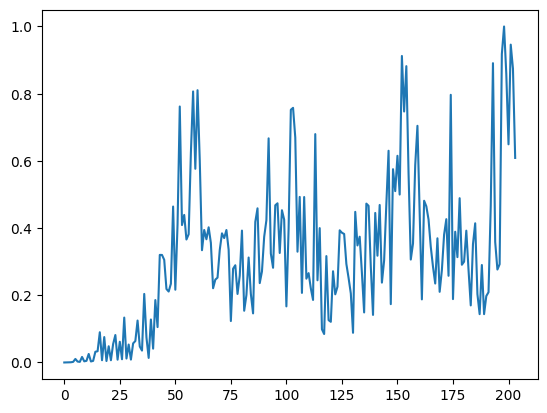

,time,bandwidth,throughput,avg_response_time,avg_connect_time,avg_latency,value
0,2023-04-12 21:41:51,1699040.0,2.67,191.25,60.88,137.75,0.000000
1,2023-04-12 21:41:54,1274397.0,2.00,230.50,45.50,146.17,0.000218
2,2023-04-12 21:41:57,1486742.0,2.33,221.00,44.29,149.29,0.000166
3,2023-04-12 21:42:00,1486797.0,2.33,307.86,51.00,216.14,0.000649
4,2023-04-12 21:42:03,1699081.0,2.67,511.88,45.88,260.63,0.001785


In [4]:
# Preprocessing
df['time'] = pd.to_datetime(df['time'])
df = df.sort_values(by='time')
time = np.arange(len(df['time']))

df['value'] = scaler.fit_transform(df[['avg_response_time']])

plt.plot(df['value'])
plt.show()

df.head()

In [12]:
window_size = 14
X, y = create_sequences(df['value'], window_size)
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, shuffle=False)

model = train_LSTM(window_size, X_train, X_test, y_train, y_test, epochs=50, lr=0.01)
# train_loss=0.0035, val_loss=0.0429 (lr=0.01)
# train_loss=0.0177, val_loss=0.0378 (lr=0.001)

(189, 14) (189, 14)
Epoch 1/50, train_loss=0.0803, val_loss=0.0864
Epoch 2/50, train_loss=0.0471, val_loss=0.0965
Epoch 3/50, train_loss=0.0439, val_loss=0.0749
Epoch 4/50, train_loss=0.0413, val_loss=0.0901
Epoch 5/50, train_loss=0.0409, val_loss=0.0777
Epoch 6/50, train_loss=0.0381, val_loss=0.0787
Epoch 7/50, train_loss=0.0321, val_loss=0.0704
Epoch 8/50, train_loss=0.0289, val_loss=0.0754
Epoch 9/50, train_loss=0.0254, val_loss=0.0746
Epoch 10/50, train_loss=0.0239, val_loss=0.0736
Epoch 11/50, train_loss=0.0234, val_loss=0.0677
Epoch 12/50, train_loss=0.0222, val_loss=0.0591
Epoch 13/50, train_loss=0.0217, val_loss=0.0583
Epoch 14/50, train_loss=0.0215, val_loss=0.0603
Epoch 15/50, train_loss=0.0210, val_loss=0.0626
Epoch 16/50, train_loss=0.0214, val_loss=0.0633
Epoch 17/50, train_loss=0.0216, val_loss=0.0589
Epoch 18/50, train_loss=0.0214, val_loss=0.0582
Epoch 19/50, train_loss=0.0214, val_loss=0.0579
Epoch 20/50, train_loss=0.0212, val_loss=0.0582
Epoch 21/50, train_loss=0.020

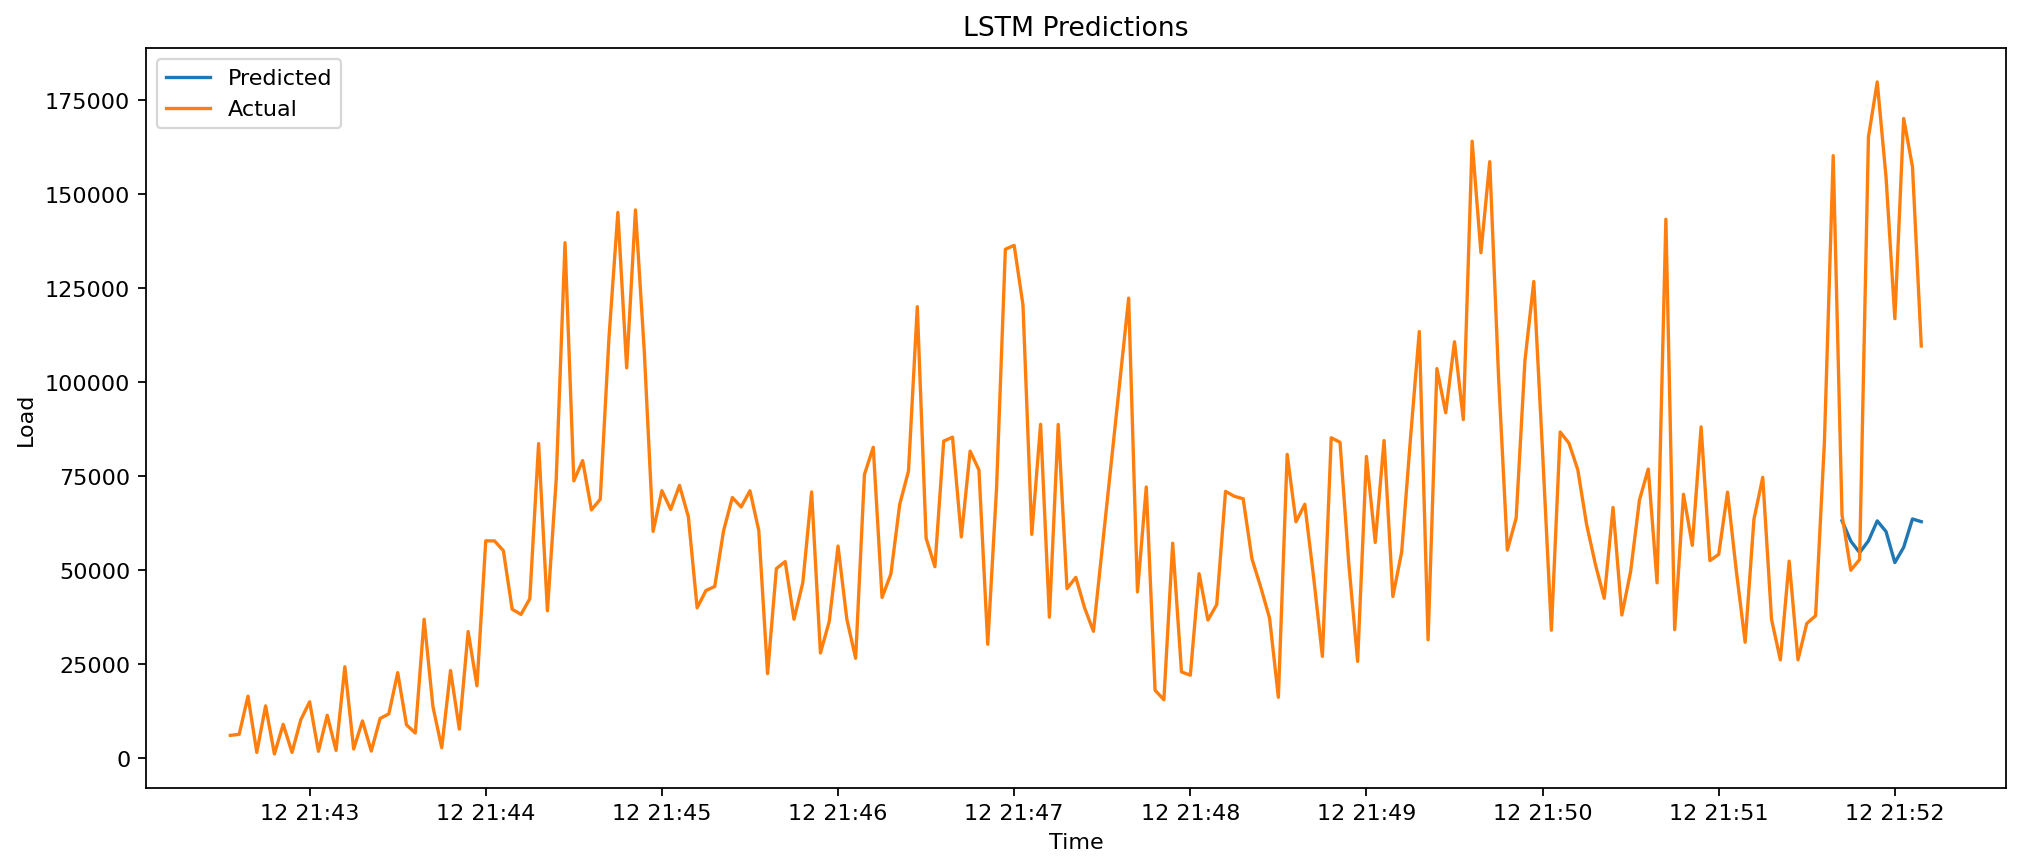

In [13]:
predict_LSTM(model, window_size, df['avg_response_time'], X_test, df['time'])

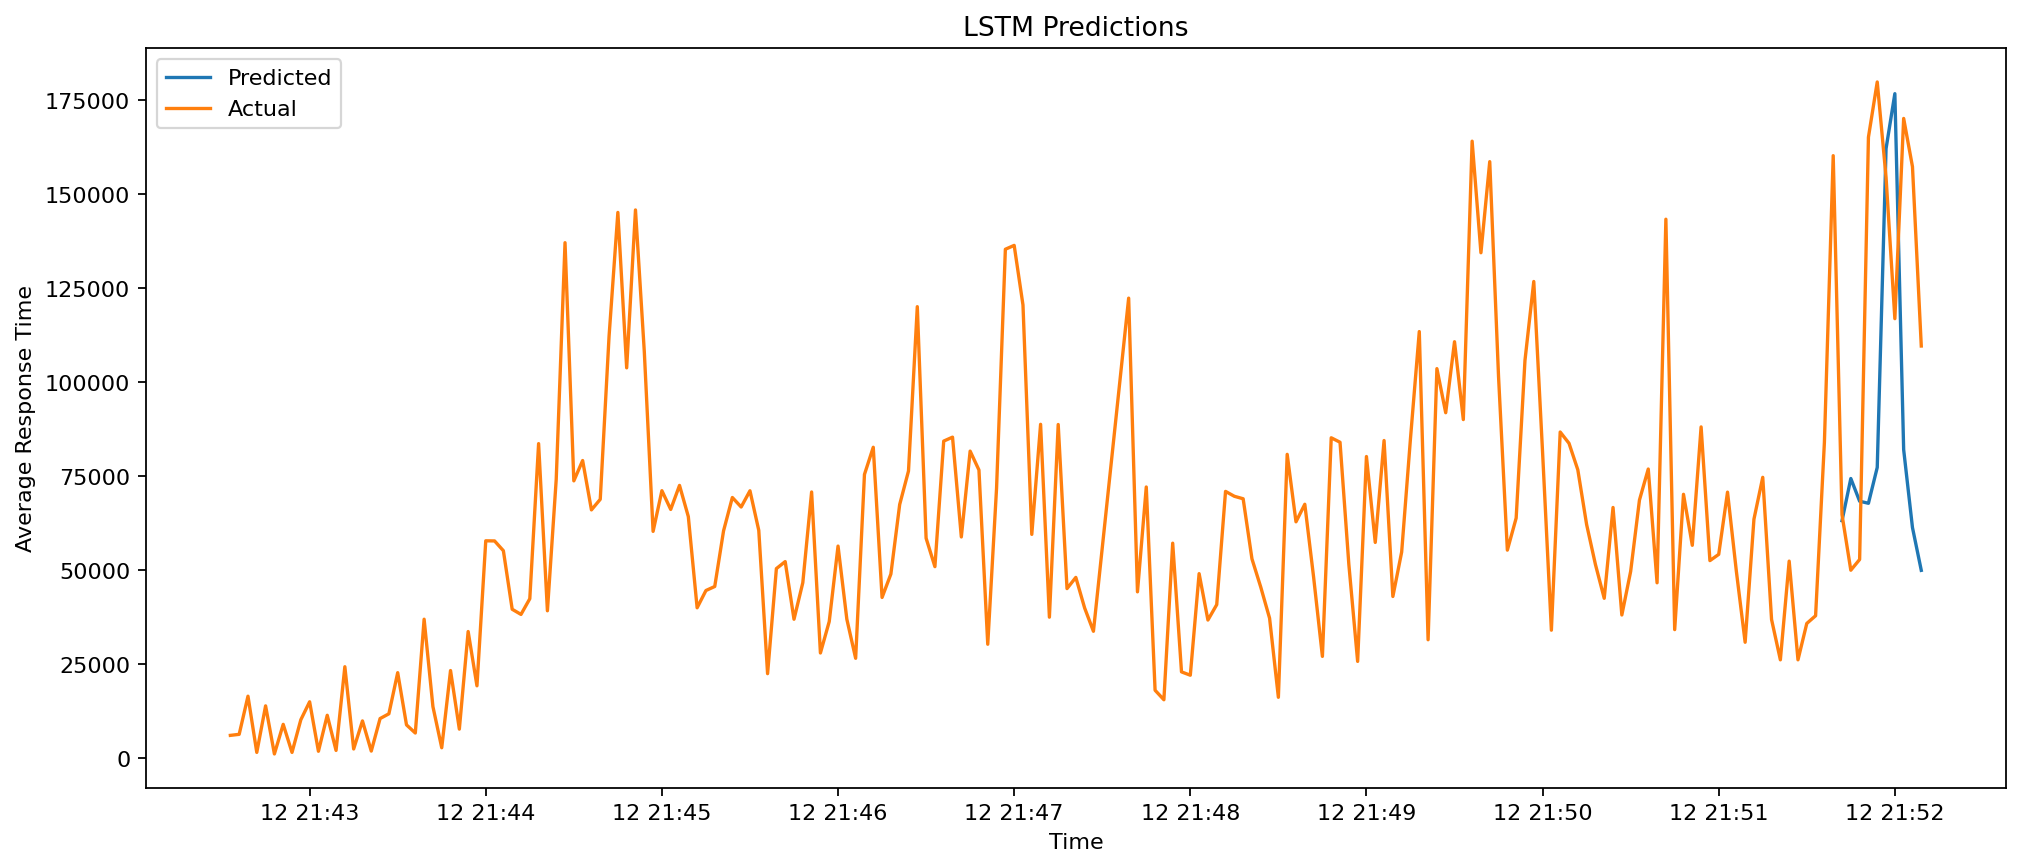

In [14]:
predict_with_truth_LSTM(model, window_size, df['avg_response_time'], X_test, df['time'])

## Dataset 2

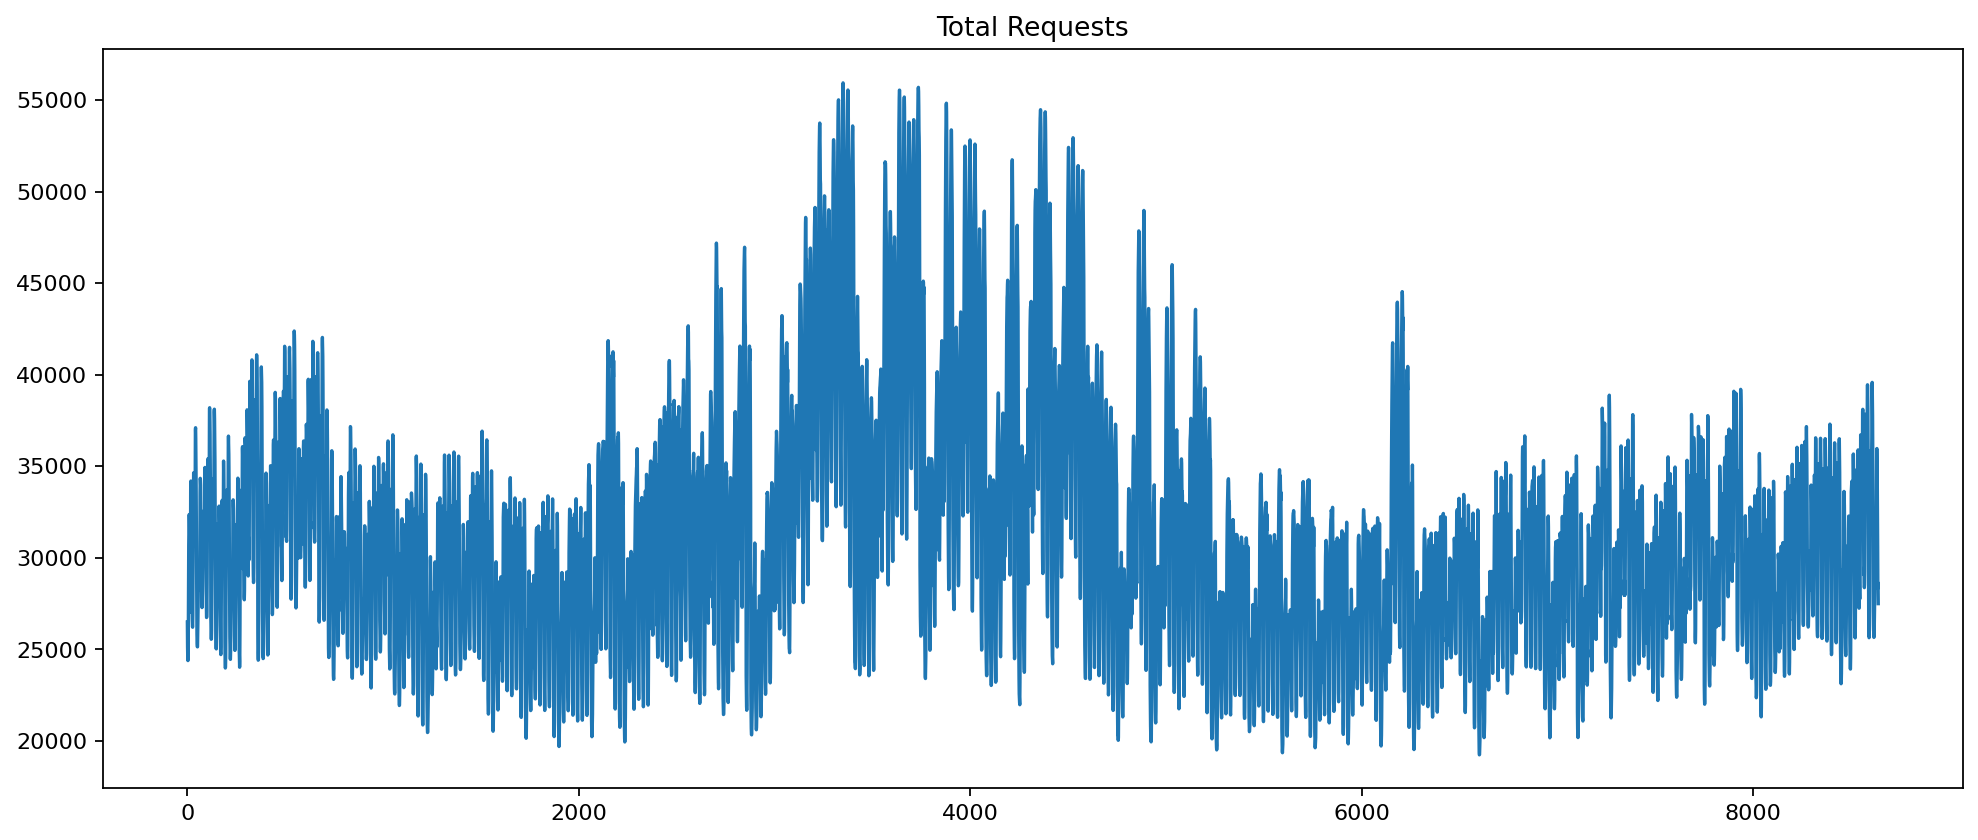

In [54]:
df = pd.read_csv('datasets/PJME_hourly.csv')

df = df[:24*30*12]
df.set_index('Datetime', inplace=True)
df.index = pd.to_datetime(df.index)

vals = df['PJME_MW'].values
time = np.arange(0, len(vals)).reshape(-1, 1)

fig = plt.figure(figsize=(15, 6), dpi=160)
plt.plot(time, vals)
plt.title('Total Requests')
plt.show()

In [55]:
# Preprocessing
scaler = MinMaxScaler()
df['value'] = scaler.fit_transform(df[['PJME_MW']])

In [56]:
window_size = 24*7*2
X, y = create_sequences(df['value'], window_size)
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42, shuffle=False)

model = train_LSTM(window_size, X_train, X_test, y_train, y_test, epochs=10, lr=0.001)

(8303, 336) (8303, 336)
Epoch 1/10, train_loss=0.0160, val_loss=0.0015
Epoch 2/10, train_loss=0.0012, val_loss=0.0009
Epoch 3/10, train_loss=0.0008, val_loss=0.0004
Epoch 4/10, train_loss=0.0006, val_loss=0.0005
Epoch 5/10, train_loss=0.0005, val_loss=0.0003
Epoch 6/10, train_loss=0.0005, val_loss=0.0003
Epoch 7/10, train_loss=0.0004, val_loss=0.0002
Epoch 8/10, train_loss=0.0004, val_loss=0.0003
Epoch 9/10, train_loss=0.0003, val_loss=0.0002
Epoch 10/10, train_loss=0.0003, val_loss=0.0004


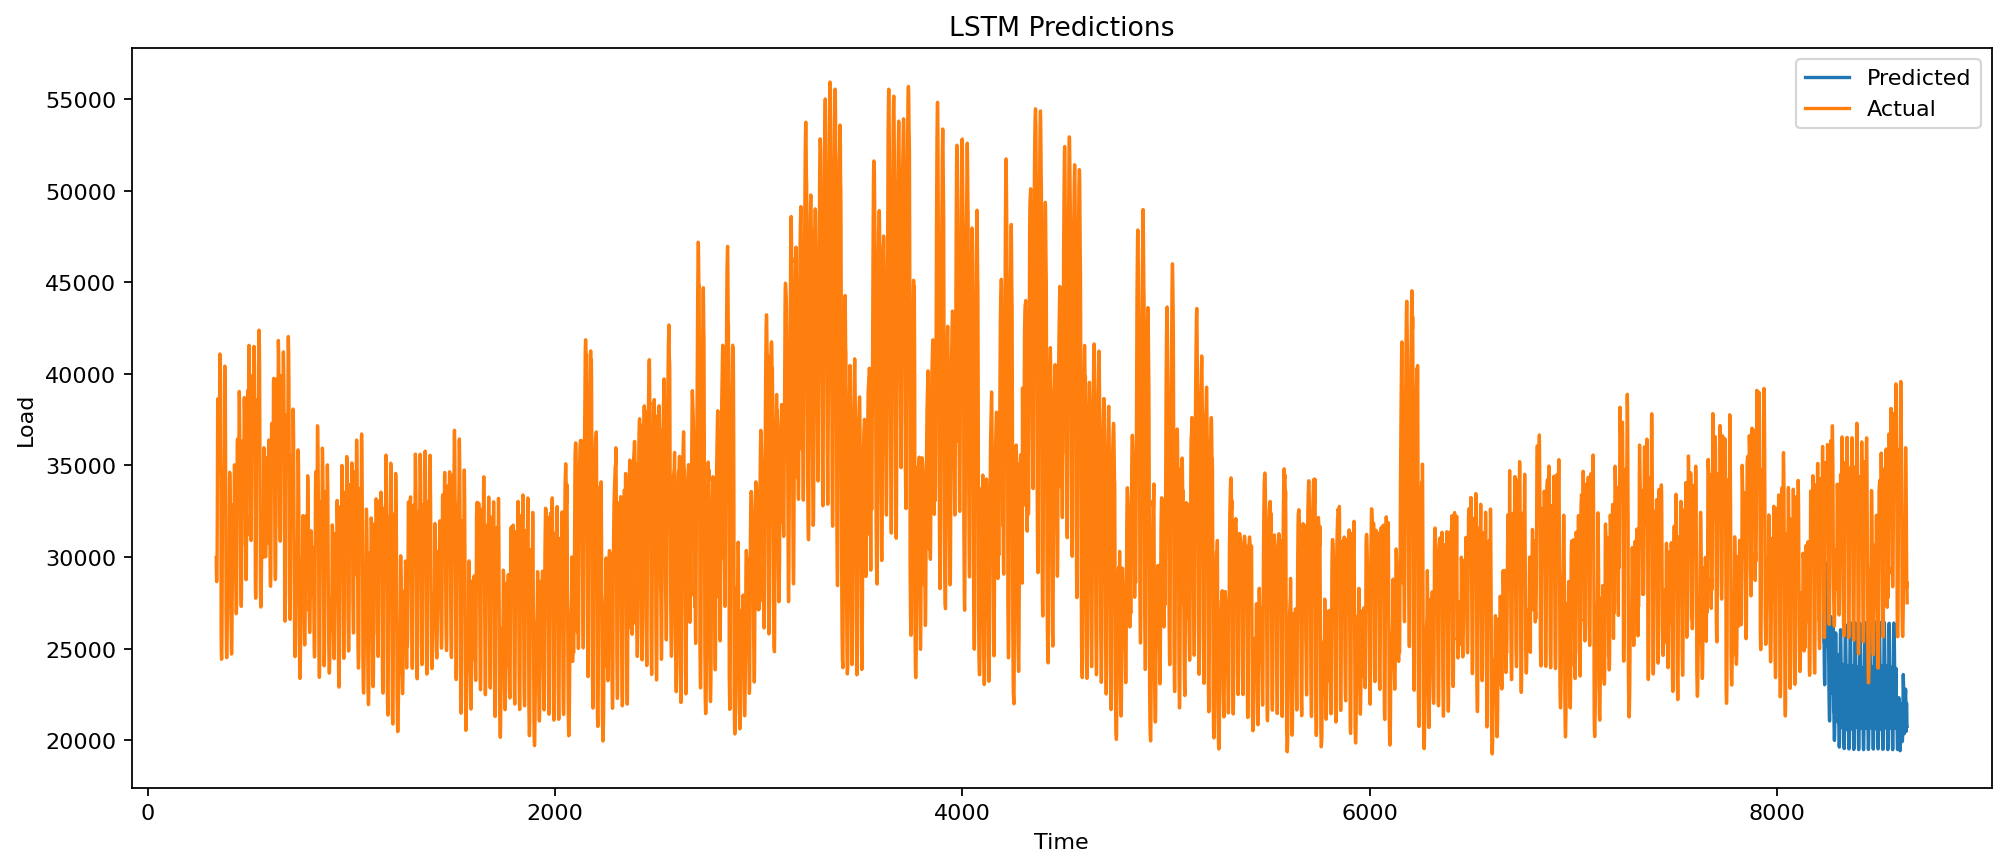

In [57]:
predict_LSTM(model, window_size, df['PJME_MW'], X_test, time)

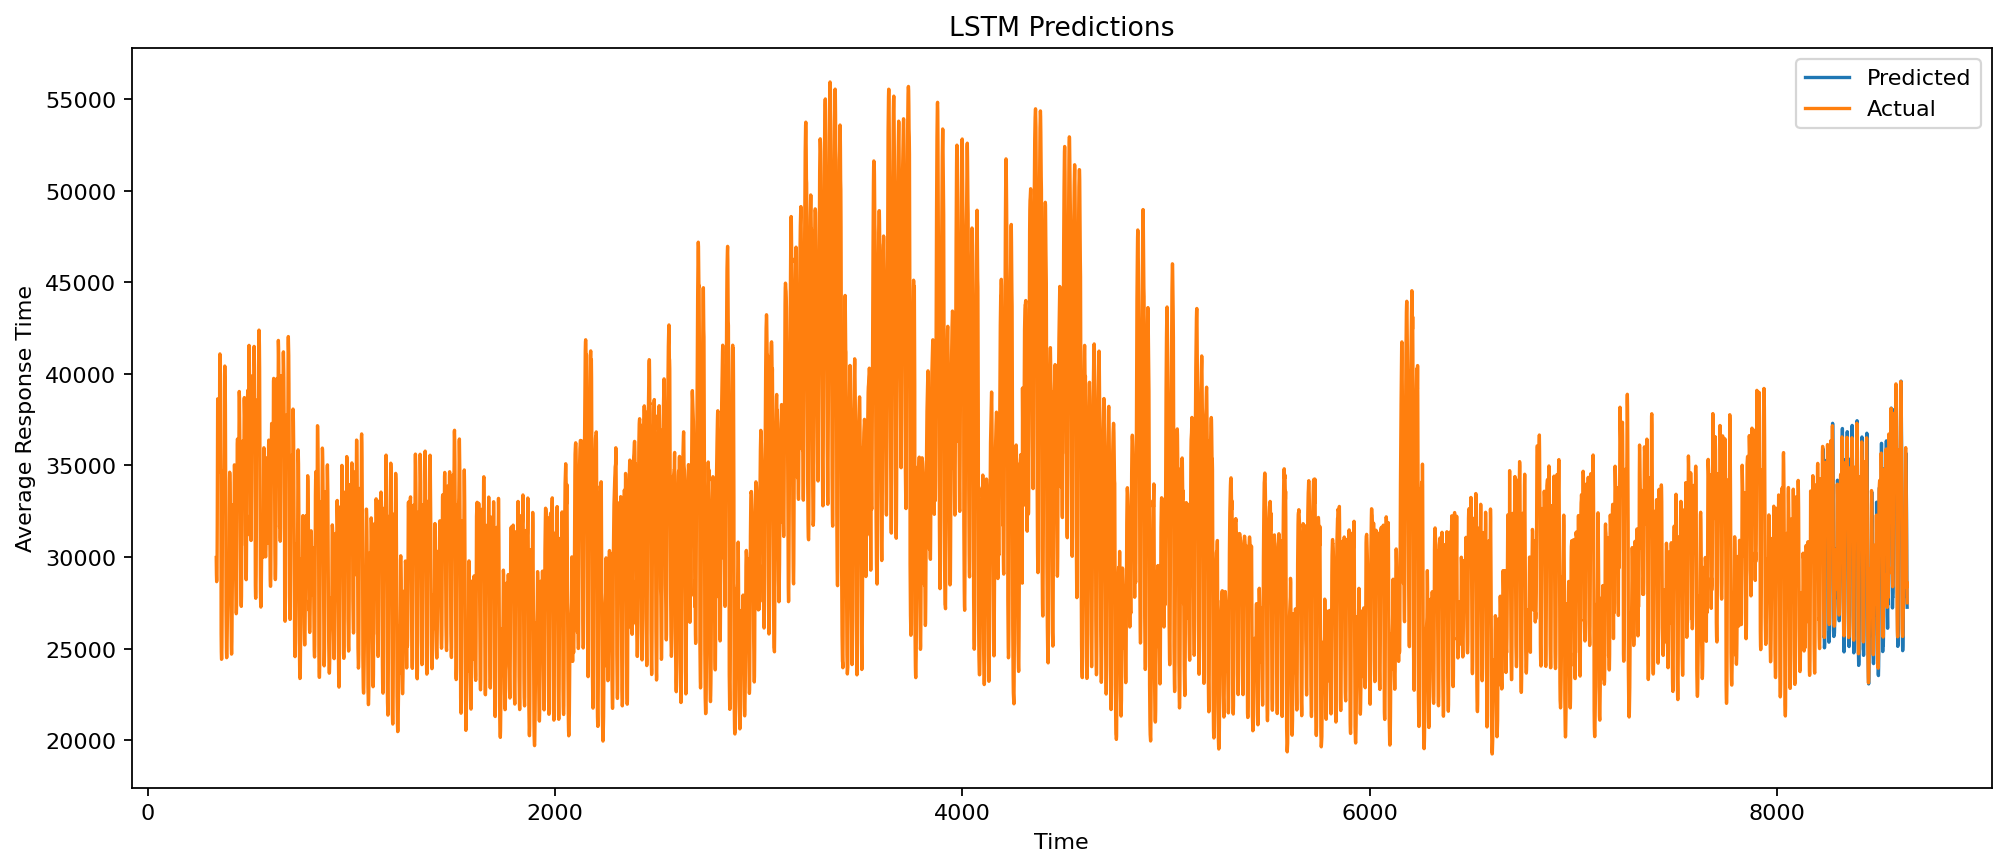

In [58]:
predict_with_truth_LSTM(model, window_size, df['PJME_MW'], X_test, time)

## Dataset 3 

In [40]:
df = pd.read_csv('datasets/daily-website-visitors.csv')
df['Page.Loads'] = df['Page.Loads'].apply(lambda x: int(x.replace(',', '')))
print(df.shape)
df.head()

(2167, 8)


,Row,Day,Day.Of.Week,Date,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
0,1,Sunday,1,9/14/2014,2146,"1,582","1,430",152
1,2,Monday,2,9/15/2014,3621,"2,528","2,297",231
2,3,Tuesday,3,9/16/2014,3698,"2,630","2,352",278
3,4,Wednesday,4,9/17/2014,3667,"2,614","2,327",287
4,5,Thursday,5,9/18/2014,3316,"2,366","2,130",236


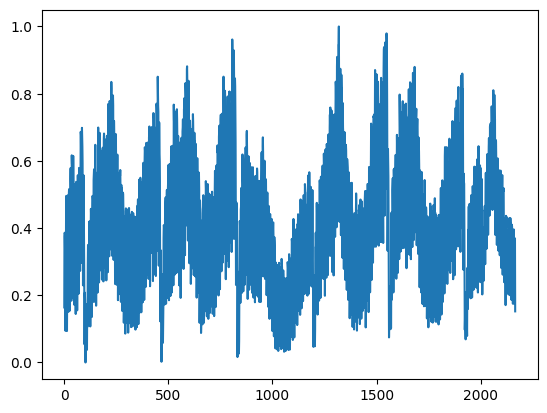

,time,value
0,2014-09-14,0.163850
1,2014-09-15,0.375107
2,2014-09-16,0.386136
3,2014-09-17,0.381696
4,2014-09-18,0.331424


In [41]:
# Preprocessing
df['time'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='time')
time = np.arange(len(df['time']))

df['value'] = scaler.fit_transform(df[['Page.Loads']])

plt.plot(df['value'])
plt.show()

df[['time', 'value']].head()

In [42]:
window_size = 30
X, y = create_sequences(df['value'], window_size)
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

model = train_LSTM(window_size, X_train, X_test, y_train, y_test, epochs=20, lr=0.001)

(2136, 30) (2136, 30)
Epoch 1/20, train_loss=0.0603, val_loss=0.0238
Epoch 2/20, train_loss=0.0343, val_loss=0.0171
Epoch 3/20, train_loss=0.0294, val_loss=0.0150
Epoch 4/20, train_loss=0.0244, val_loss=0.0121
Epoch 5/20, train_loss=0.0118, val_loss=0.0053
Epoch 6/20, train_loss=0.0066, val_loss=0.0036
Epoch 7/20, train_loss=0.0050, val_loss=0.0036
Epoch 8/20, train_loss=0.0047, val_loss=0.0040
Epoch 9/20, train_loss=0.0044, val_loss=0.0036
Epoch 10/20, train_loss=0.0042, val_loss=0.0042
Epoch 11/20, train_loss=0.0040, val_loss=0.0034
Epoch 12/20, train_loss=0.0039, val_loss=0.0033
Epoch 13/20, train_loss=0.0039, val_loss=0.0033
Epoch 14/20, train_loss=0.0038, val_loss=0.0033
Epoch 15/20, train_loss=0.0038, val_loss=0.0036
Epoch 16/20, train_loss=0.0037, val_loss=0.0036
Epoch 17/20, train_loss=0.0038, val_loss=0.0035
Epoch 18/20, train_loss=0.0036, val_loss=0.0040
Epoch 19/20, train_loss=0.0036, val_loss=0.0036
Epoch 20/20, train_loss=0.0036, val_loss=0.0040


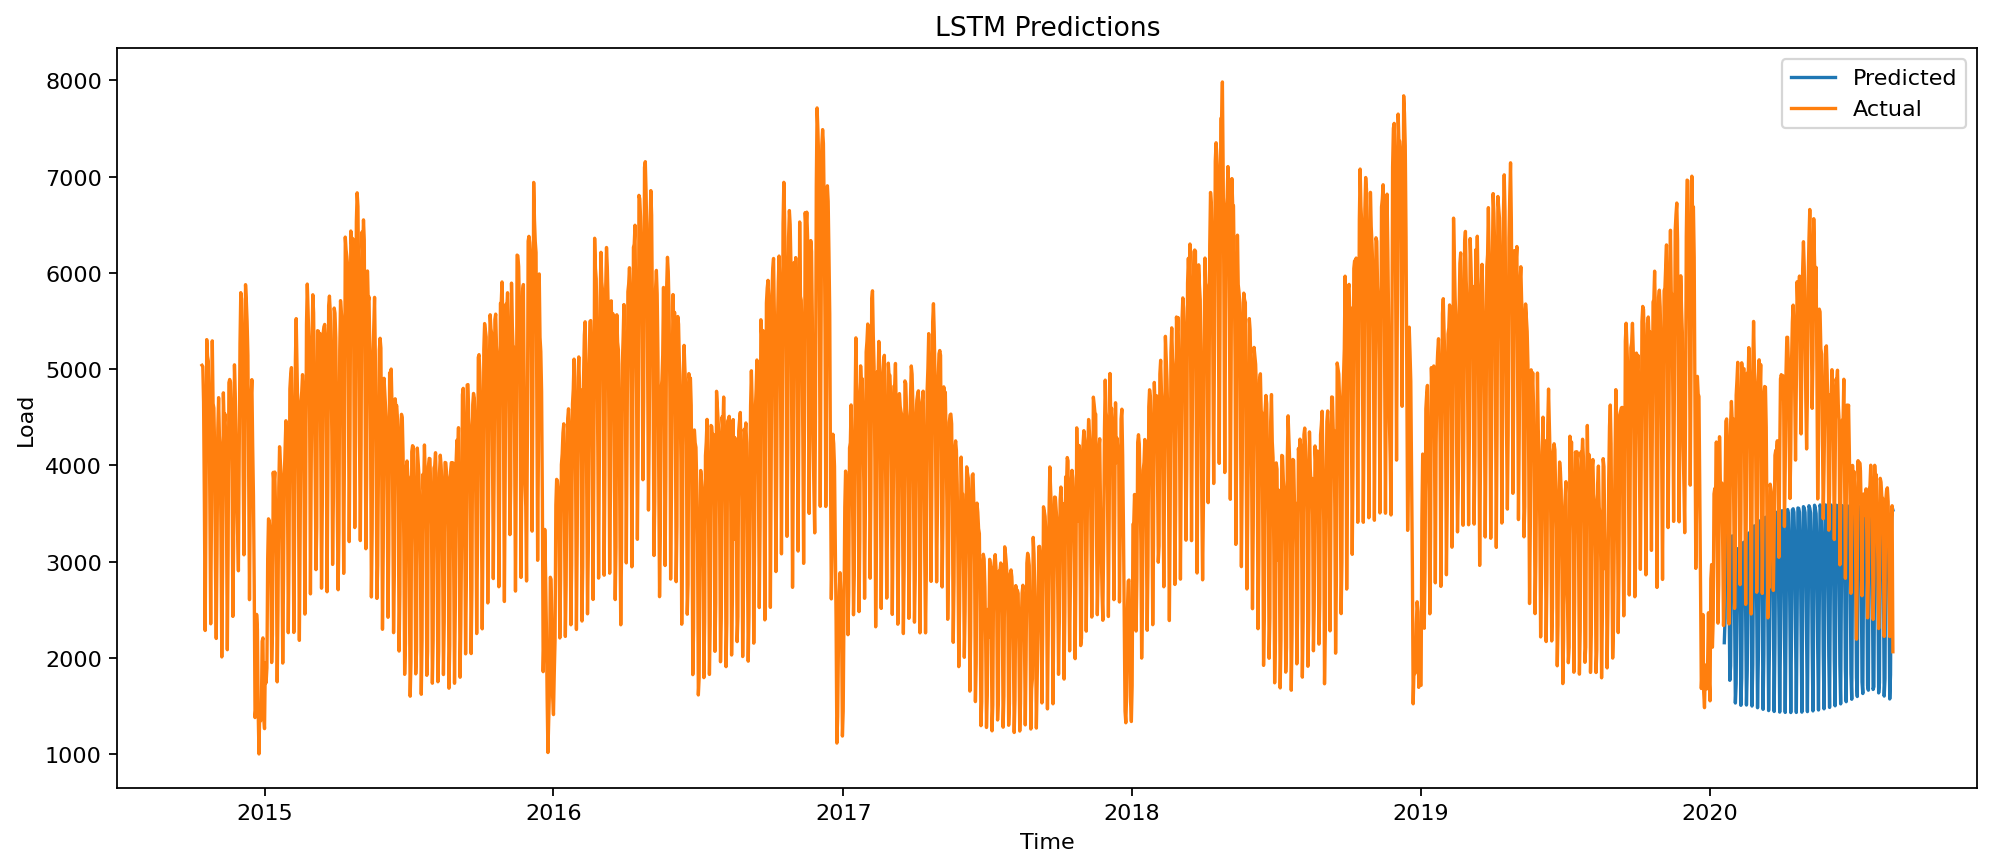

In [43]:
predict_LSTM(model, window_size, df['Page.Loads'], X_test, df['time'])


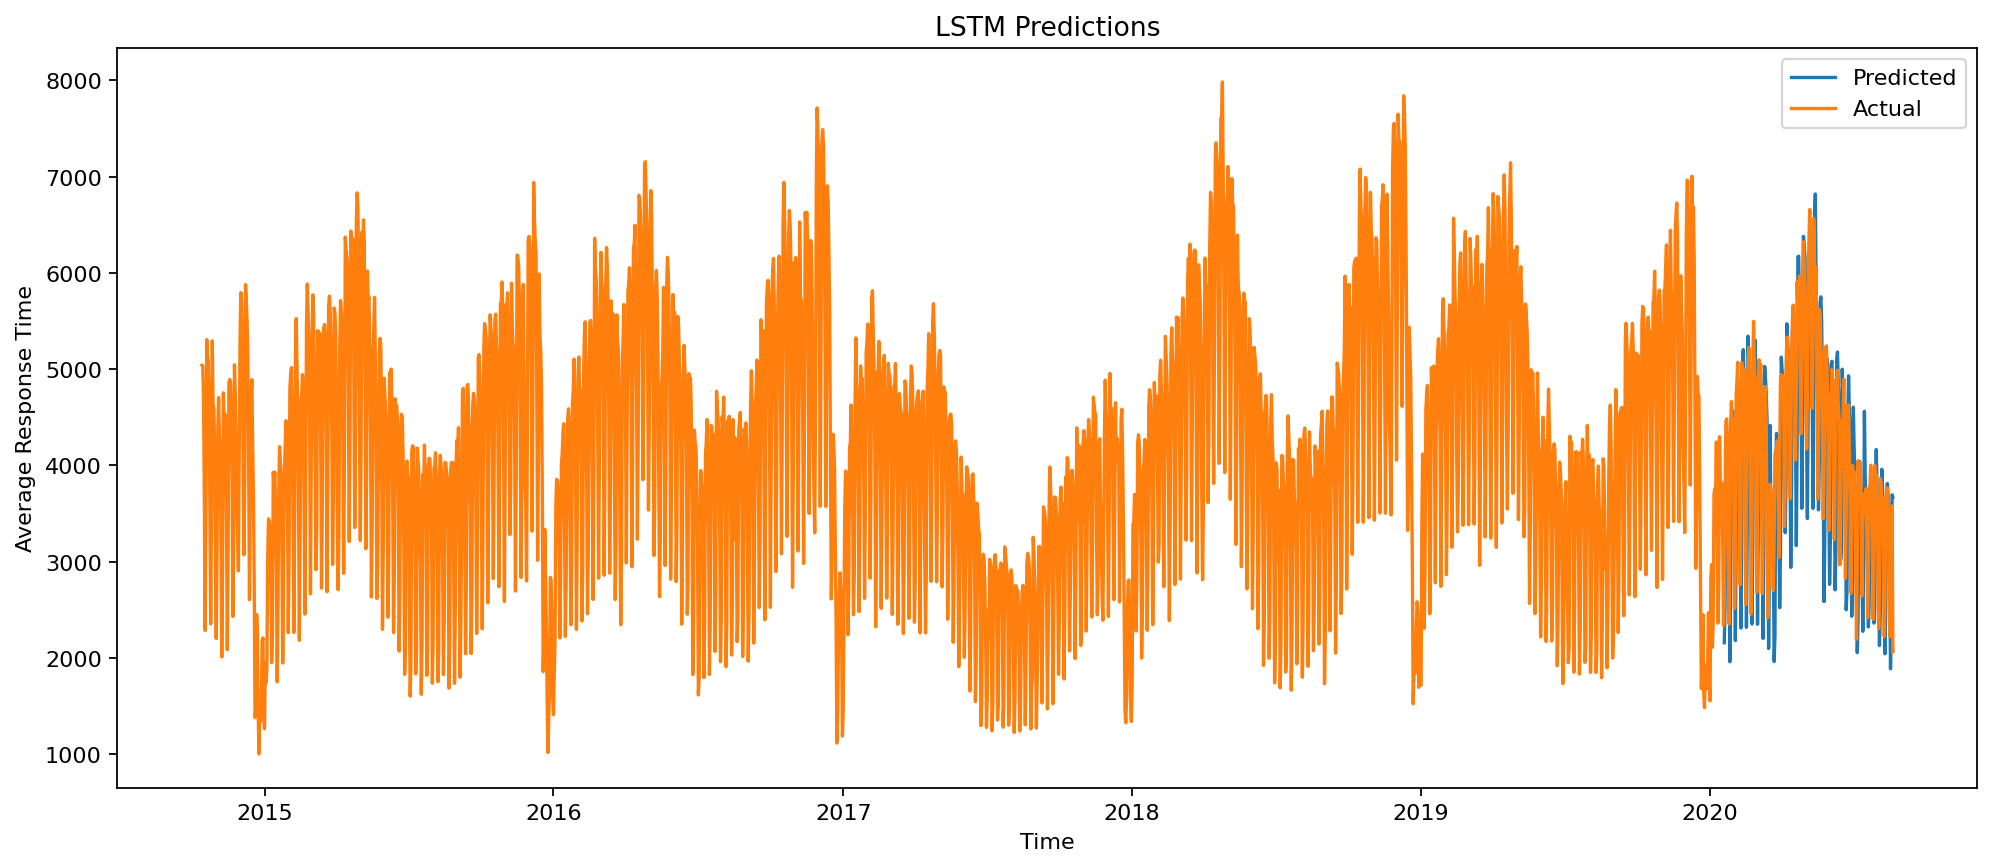

In [44]:
predict_with_truth_LSTM(model, window_size, df['Page.Loads'], X_test, df['time'])
